In [9]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [14,10]
from scipy.stats import median_absolute_deviation as mad

In [2]:
import sys
sys.path.append('../../decode_rf_data')
import healpy as hp
from colormap import spectral, jade, kelp
jade, _ = jade()

In [3]:
import numpy as np
import healpy as hp
from scipy.stats import median_absolute_deviation as mad


def plot_healpix(data_map=None,sub=None,title=None,vmin=None,vmax=None,cmap=None):
    '''Yeesh do some healpix magic to plot the thing'''
    
    # Disable cryptic healpy warnings. Can't figure out where they originate
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 
    
    if vmin == None:
        if cmap == None:
            half_sky = hp.orthview(
                    map=data_map,coord='E',
                    half_sky=True,xsize=400,
                    title=title,rot=(0,90,0),
                    sub=sub,notext=True, return_projected_map=True)
        else:
            half_sky = hp.orthview(
                    map=data_map,coord='E',
                    half_sky=True,xsize=400,
                    title=title,rot=(0,90,0), sub=sub,cmap=cmap,
                    notext=True,return_projected_map=True)
    else:
        if cmap == None:
            half_sky = hp.orthview(
                    map=data_map,coord='E'
                    ,half_sky=True,xsize=400,rot=(0,90,0),
                    title=title,sub=sub,min=vmin,max=vmax,
                    notext=True,return_projected_map=True)
        else:
            half_sky = hp.orthview(
                    map=data_map,coord='E',
                    half_sky=True,xsize=400,rot=(0,90,0),
                    title=title,sub=sub,min=vmin,max=vmax,
                    cmap=cmap,notext=True,return_projected_map=True)

    hp.graticule(dpar=10,coord='E',color='k',alpha=0.3,dmer=45)
   
    # Altitude grid
    hp.projtext(0.0*(np.pi/180.0), 0.0, '0', coord='E')
    hp.projtext(30.0*(np.pi/180.0), 0.0, '30', coord='E')
    hp.projtext(60.0*(np.pi/180.0), 0.0, '60', coord='E')

#     # Azimuth grid
#     hp.projtext(90.0*(np.pi/180.0), 00.0*(np.pi/180.0), r'$0^\circ$', coord='E',color='k',verticalalignment='top', fontsize=12)
#     hp.projtext(90.0*(np.pi/180.0), 90.0*(np.pi/180.0), r'$90^\circ$', coord='E',color='k',horizontalalignment='right', fontsize=12)
#     hp.projtext(90.0*(np.pi/180.0), 180.0*(np.pi/180.0), r'$180^\circ$', coord='E',color='k', fontsize=12)
#     hp.projtext(90.0*(np.pi/180.0), 270.0*(np.pi/180.0), r'$270^\circ$', coord='E',color='k', fontsize=12)
    
#     # NSEW 
#     hp.projtext(90.0*(np.pi/180.0), 045.0*(np.pi/180.0), r'$N  $', coord='E',color='k',verticalalignment='top', horizontalalignment='right', fontsize=14)
#     hp.projtext(90.0*(np.pi/180.0), 135.0*(np.pi/180.0), r'$E  $', coord='E',color='k',horizontalalignment='right', fontsize=14)
#     hp.projtext(90.0*(np.pi/180.0), 225.0*(np.pi/180.0), r'$S  $', coord='E',color='k', fontsize=14)
#     hp.projtext(90.0*(np.pi/180.0), 315.0*(np.pi/180.0), r'$W  $', coord='E',color='k', verticalalignment='top', horizontalalignment='left', fontsize=14)


In [4]:
map_data = np.load('../../../outputs/tile_maps/S08XX_rf1XX_healpix_map.npz', allow_pickle=True)
map_data = {key:map_data[key].item() for key in map_data}
heal_maps = map_data['healpix_maps']
ref_maps = map_data['ref_maps']
tile_maps = map_data['tile_maps']
sat_maps = map_data['sat_map']
times = map_data['times']

heal_map = heal_maps['0']
tile_map = tile_maps['0']
ref_map = ref_maps['0']
sat_map = sat_maps['0']
times = times['0']

map_counts = [len(i) for i in heal_map]

In [5]:
heal_mads = [mad(i) for i in heal_map]
np.nanargmax(heal_mads)

134

In [6]:
np.argmax(map_counts)

5193

In [7]:
def plt_pix_data(ref, tile, heal, pix):
    ref_data = ref[pix]
    tile_data = tile[pix]
    heal_data = heal[pix]
    pix_sat_data = sat_map[pix]
    pix_time_data = times[pix]
        
    f, axes = plt.subplots(1, 1, figsize=(14, 6), sharex=True)
    norad_ids, counts = np.unique(pix_sat_data, return_counts=True)
    sns.set()
    index = np.arange(len(norad_ids))
    plt.bar(index, counts, color=sns.color_palette('Spectral', len(counts)), alpha=0.9)
    plt.xticks(index, norad_ids, rotation=90)
    plt.title(f'Satellite passes in Healpix pixel: {pix}')
    plt.tight_layout()
    plt.show()
    plt.close()
        
    ref_sat_data = {n:np.asarray(ref_data)[np.where(np.asarray(pix_sat_data) == n)] for n in norad_ids}
    tile_sat_data = {n:np.asarray(tile_data)[np.where(np.asarray(pix_sat_data) == n)] for n in norad_ids}
    heal_sat_data = {n:np.asarray(heal_data)[np.where(np.asarray(pix_sat_data) == n)] for n in norad_ids}
    time_data = {n:np.asarray((np.asarray(pix_time_data)-pix_time_data[0])/(60*60*24))[np.where(np.asarray(pix_sat_data) == n)] for n in norad_ids}    
    n = len(time_data)
    colors = pl.cm.Spectral(np.linspace(0,1,n))
    
    for k in range(n):
        plt.scatter(time_data[norad_ids[k]], ref_sat_data[norad_ids[k]],s=70, color=colors[k], edgecolors='grey', label=f'{norad_ids[k]}')
        
    plt.xlabel('Days from start')
    plt.title(f'REF Power in Pix: {pix}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    for k in range(n):
        plt.scatter(time_data[norad_ids[k]], tile_sat_data[norad_ids[k]],s=70, color=colors[k], edgecolors='grey', label=f'{norad_ids[k]}')
        
    plt.xlabel('Days from start')
    plt.title(f'Tile Power in Pix: {pix}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

    for k in range(n):
        plt.scatter(time_data[norad_ids[k]], heal_sat_data[norad_ids[k]],s=70, color=colors[k], edgecolors='grey', label=f'{norad_ids[k]}')
    
    med = np.median(heal_data)
    MAD = mad(heal_data)
    
    print(f'Passes: {len(tile_data)}, Median: {med}, MAD: {MAD}')
    
    plt.axhline(y=med)
    plt.axhspan(ymin=(med-MAD), ymax=(med+MAD), alpha=0.1)
    plt.xlabel('Days from start')
    plt.title(f'DIFF Power in Pix: {pix}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    for k in range(n):
        sns.distplot(heal_sat_data[norad_ids[k]], bins=20, color='seagreen').set_title(f'Sat_ID: {norad_ids[k]} Counts: {len(heal_sat_data[norad_ids[k]])}')
        plt.tight_layout()
        plt.show()
        plt.close()

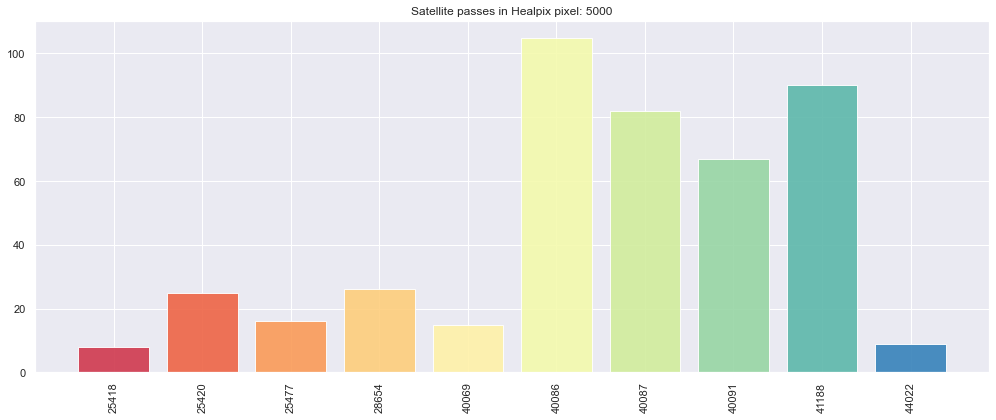

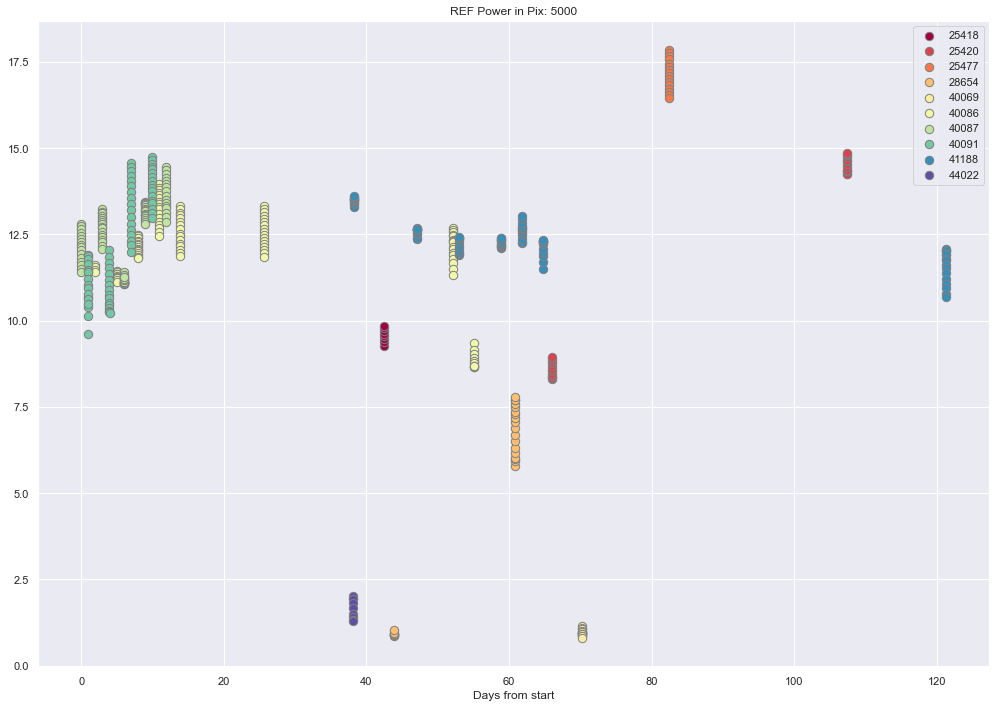

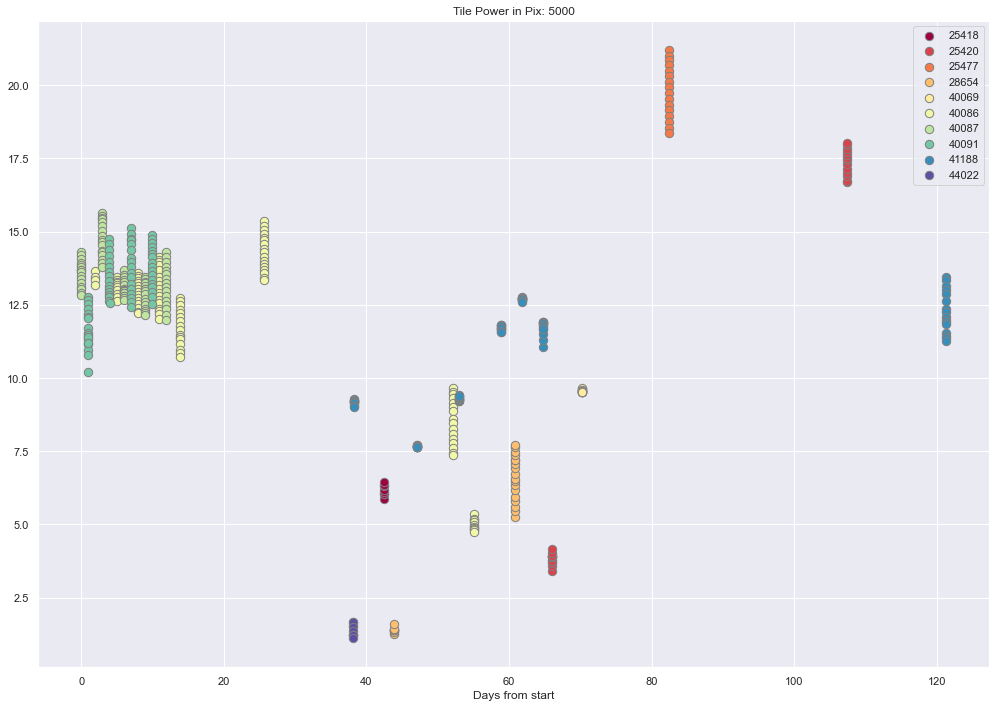

Passes: 443, Median: 0.15588760375976562, MAD: 1.8621859588623046


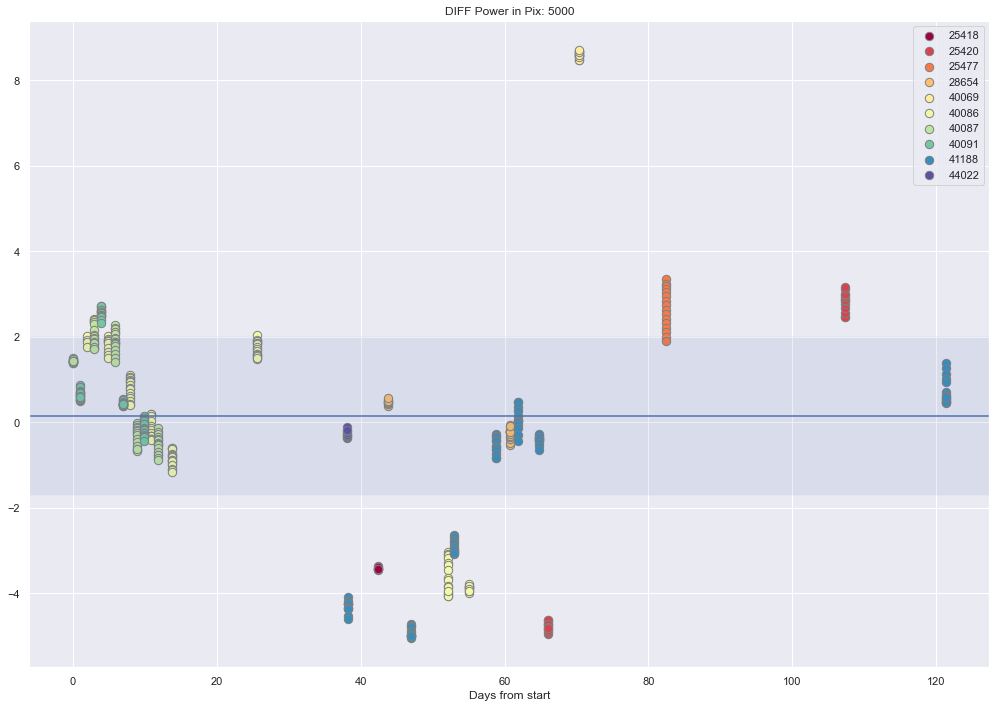

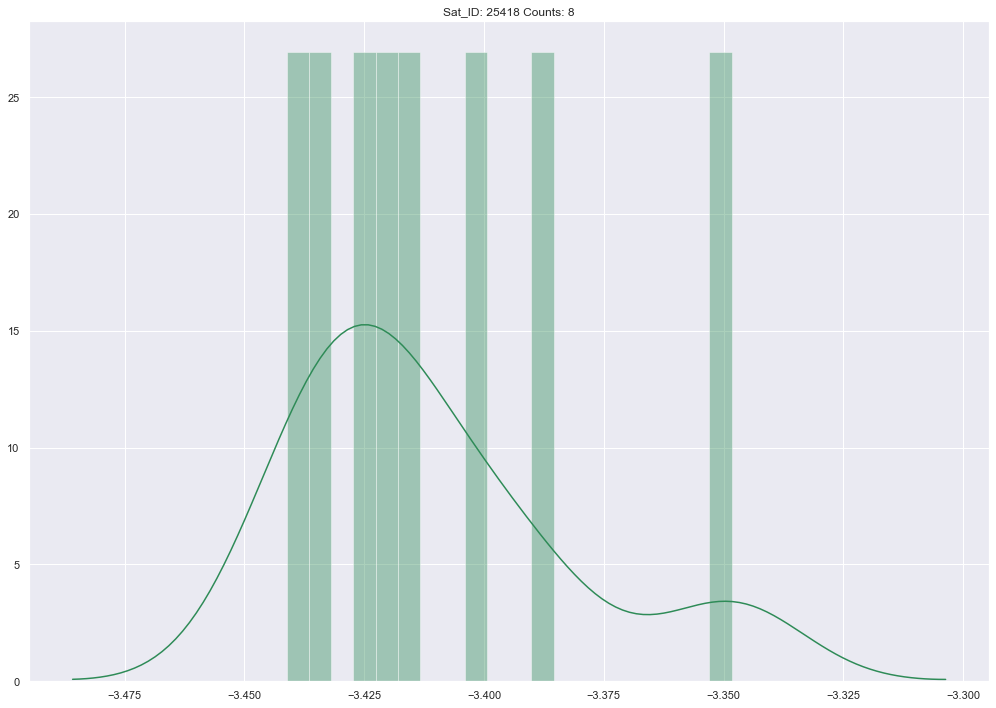

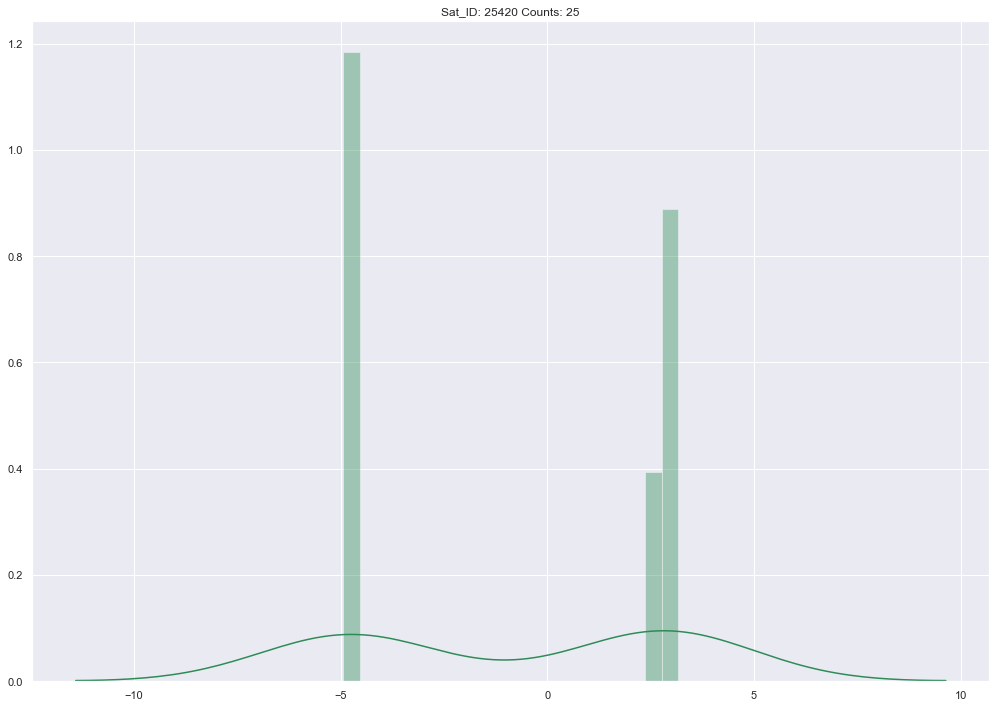

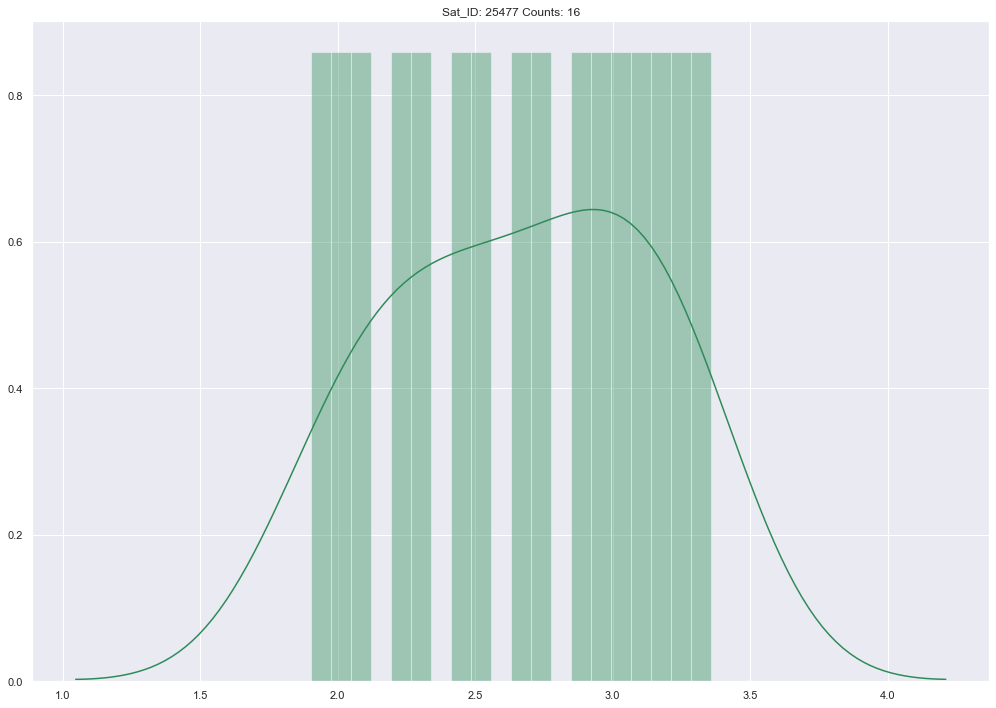

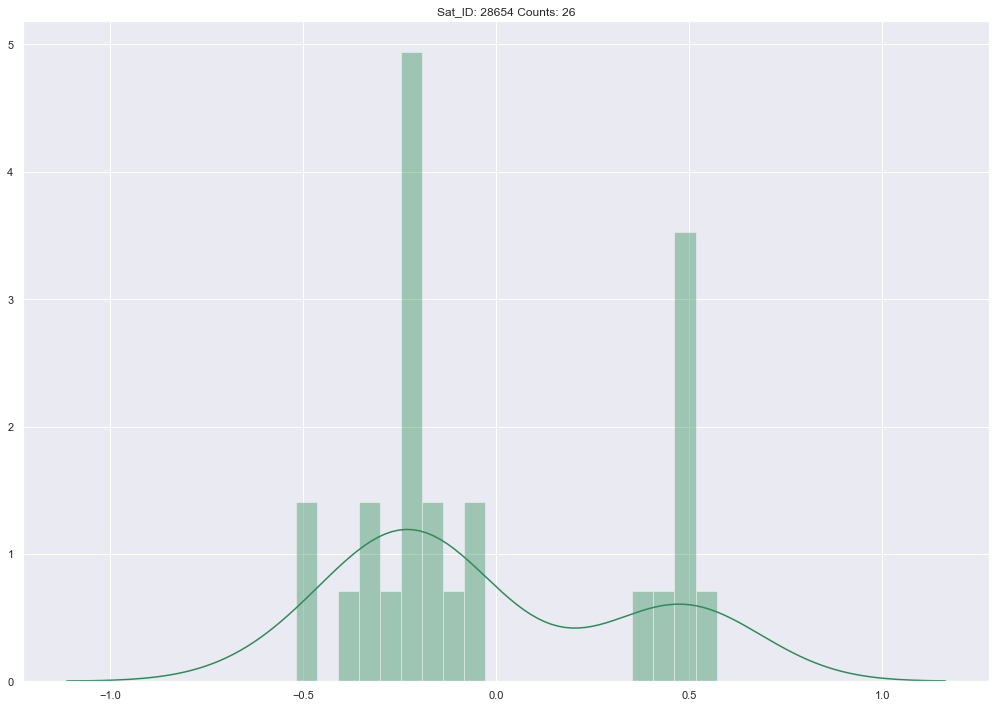

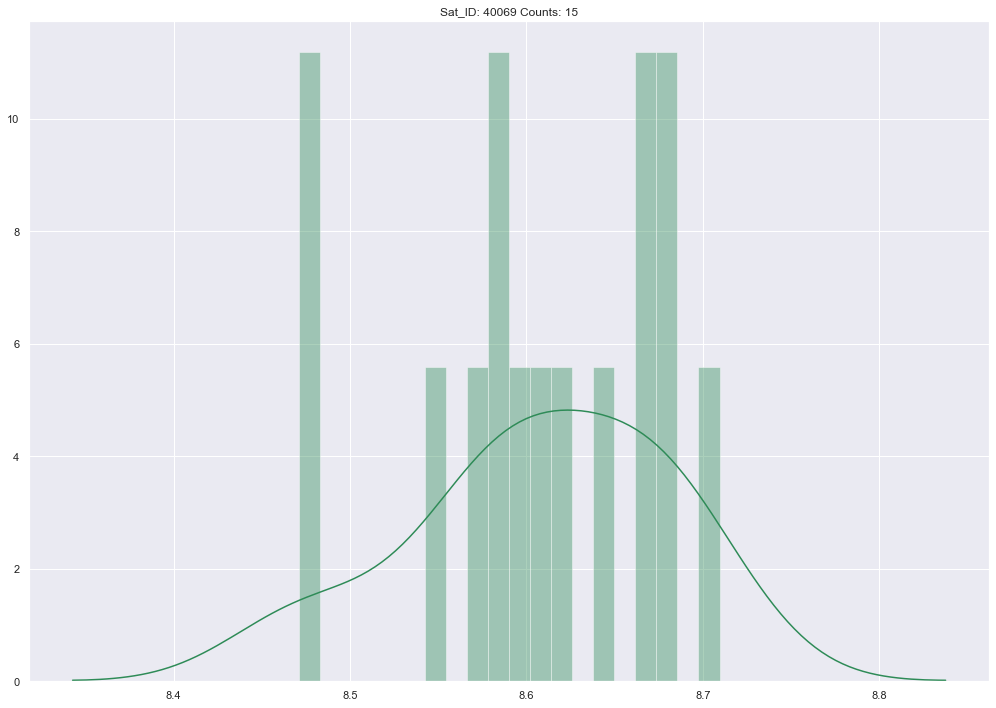

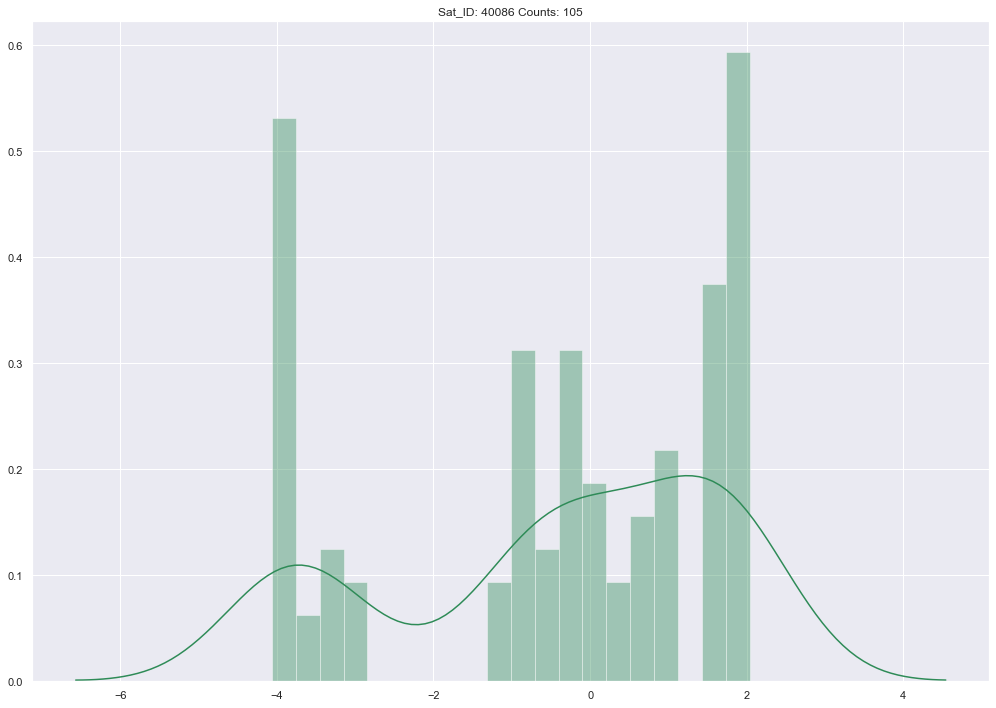

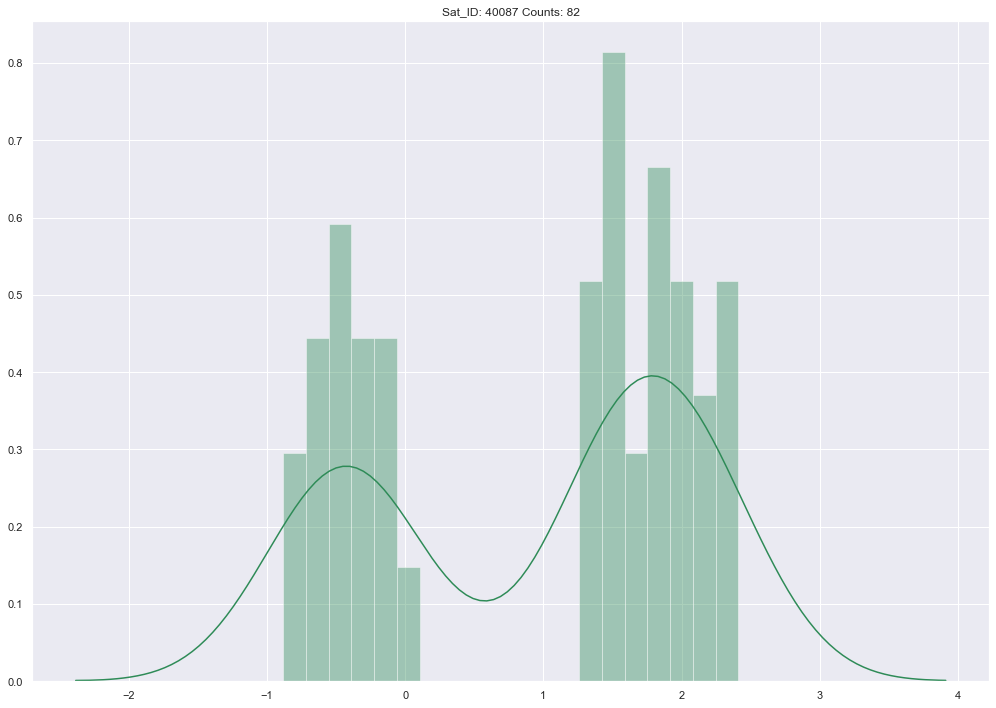

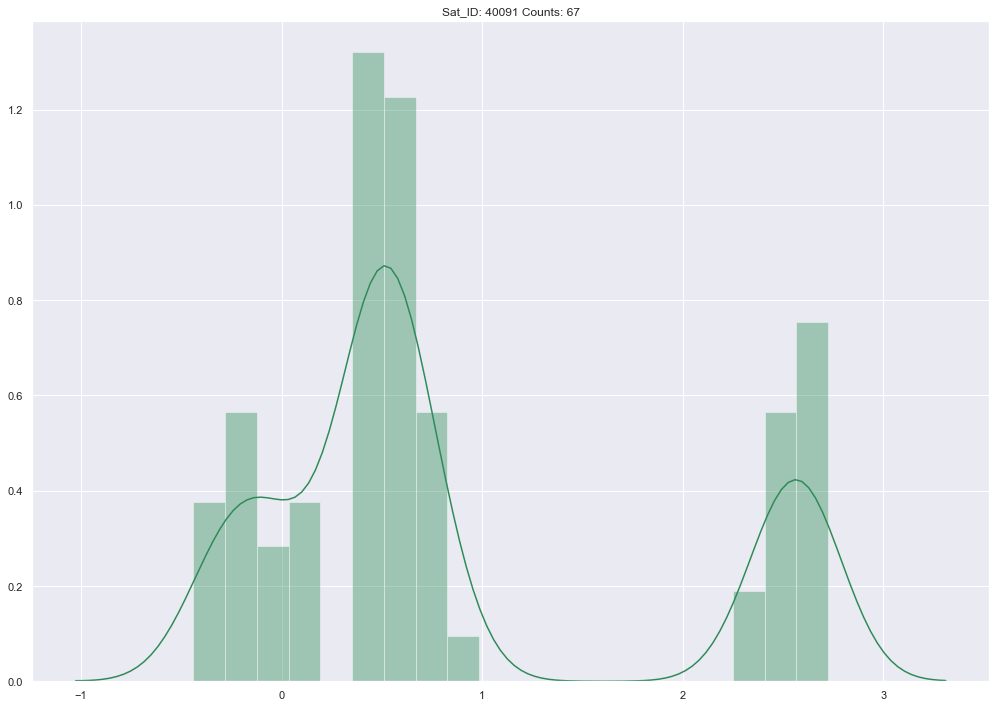

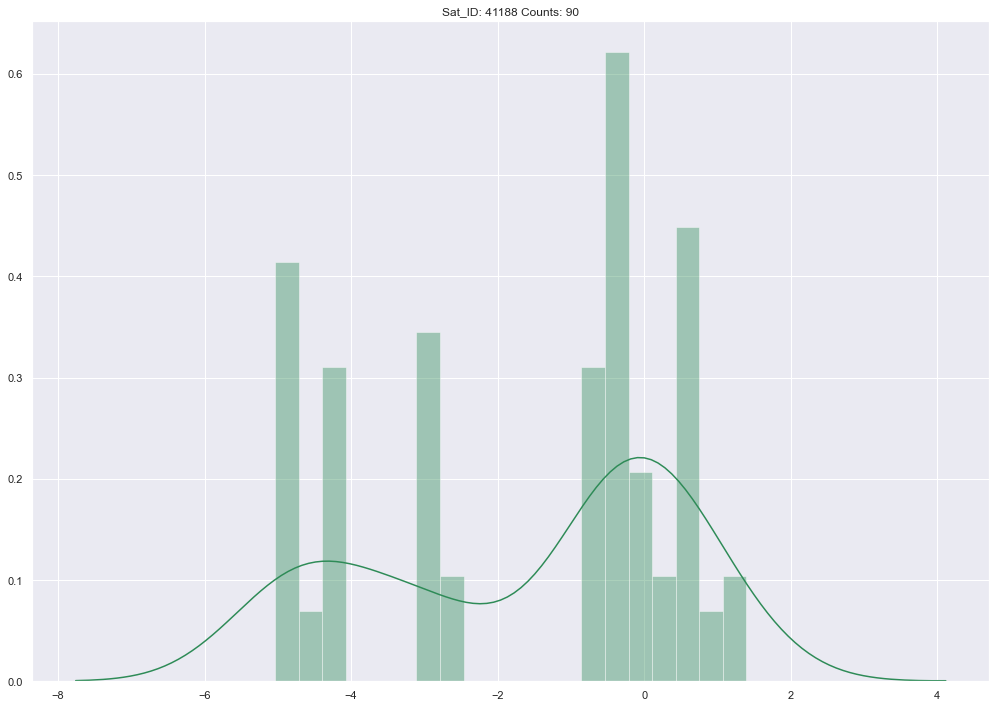

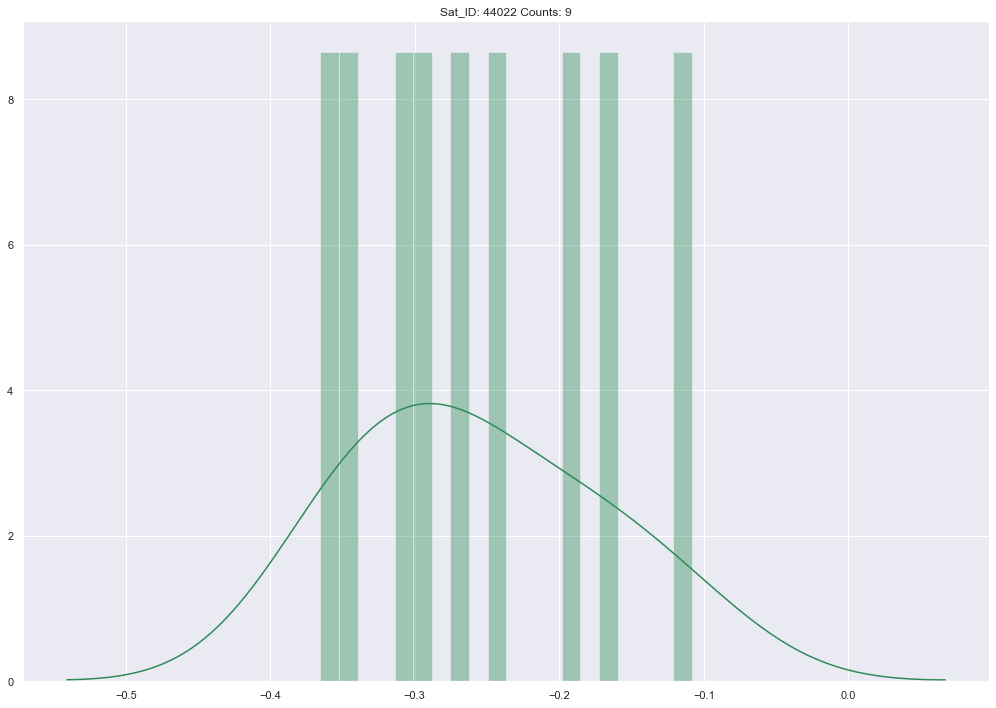

In [40]:
plt_pix_data(ref_map, tile_map, heal_map, 5000)
# pix 134 has worst MAD

In [11]:
def nan_mad(ref_map):
    '''Compute mad while ignoring nans'''
    ref_map_mad = []
    for j in ref_map:
        if j != []:
            j = np.asarray(j)
            j = j[~np.isnan(j)]
            ref_map_mad.append(mad(j))
        else:
            ref_map_mad.append(np.nan)

    ref_map_mad = np.asarray(ref_map_mad)
    ref_map_mad[np.where(ref_map_mad == np.nan)] = np.nanmean(ref_map_mad)

    return ref_map_mad

/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.


/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.


/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Applications/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 45 deg 0.00'.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


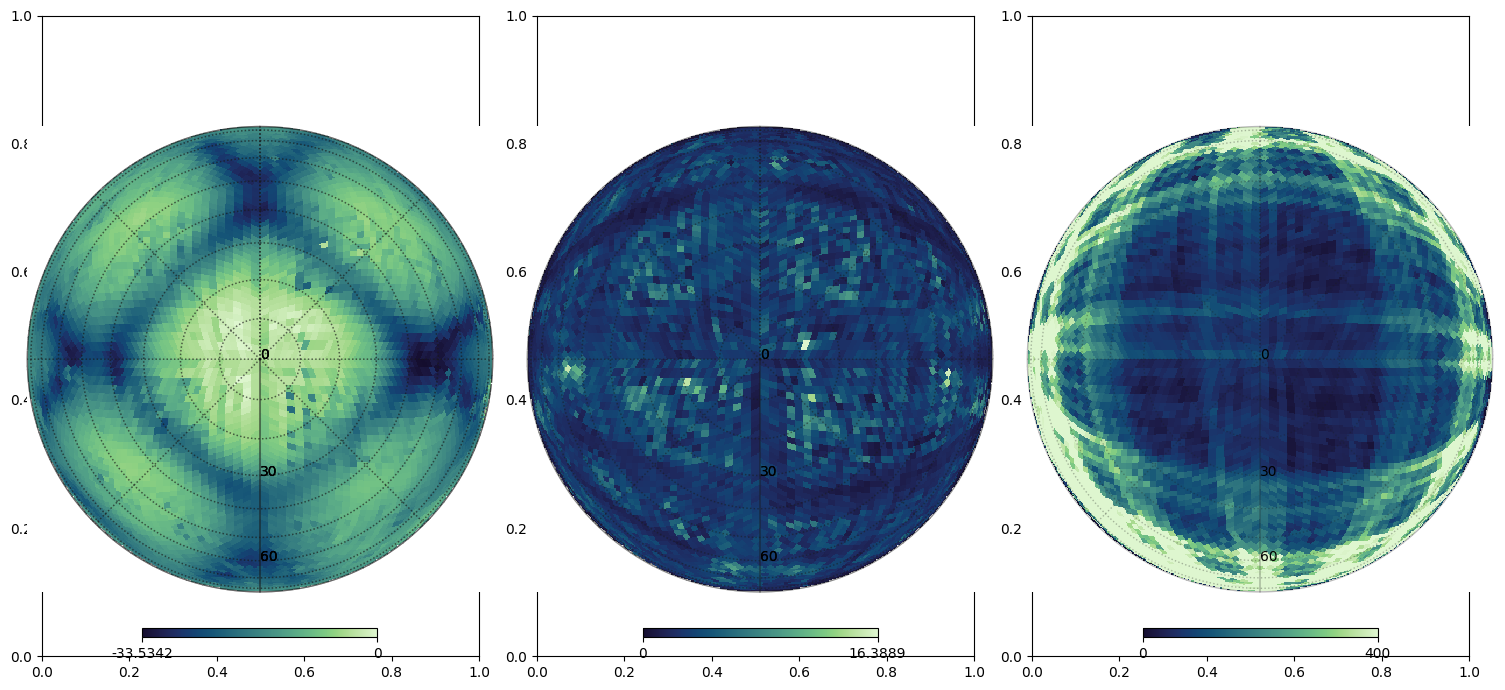

In [12]:
heal_map_med = [(np.median(i) if i != [] else np.nan ) for i in heal_map]
heal_map_med_scaled = np.asarray([(i - np.nanmax(heal_map_med[:5000])) for i in heal_map_med])
vmin = np.nanmin(heal_map_med_scaled)
#vmax = np.nanmax(tile_map_mean_scaled)
vmax = 0

heal_mad = np.asarray(nan_mad(heal_map))
mad_min = np.nanmin(heal_mad)
mad_max = np.nanmax(heal_mad)

plt.rcParams.update(plt.rcParamsDefault)

f, axes = plt.subplots(1, 3, figsize=(15, 7))
plot_healpix(data_map=np.asarray(heal_map_med_scaled),sub=(1,3,1), cmap=jade, vmin=vmin, vmax=vmax)
plot_healpix(data_map=np.asarray(heal_mad),sub=(1,3,2), cmap=jade, vmin=mad_min, vmax=mad_max)
plot_healpix(data_map=np.asarray(map_counts),sub=(1,3,3), cmap=jade, vmin=0, vmax=400)
plt.tight_layout()
plt.show()
plt.close()